<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/Exercise06_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *
# fastai.basics pakege의 모든 module을 import한다. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

deeplearning.net은 python pickle 파일 형식을 사용하는 MNIST dataset을 제공한다. python은 이 파일을 직접 열고 numpy.arrays를 직접 제공하며 numpy.arrays를 자동으로 평평하게 만들 수 있다. 

In [0]:
path = Config().data_path()/'mnist'
#path = Config().data_path()

In [0]:
path

PosixPath('/root/.fastai/data/mnist')

In [0]:
cd /root/.fastai/data

/root/.fastai/data


In [0]:
ls

mnist.pkl.gz


In [0]:
! mkdir /root/.fastai/data/mnist

In [0]:
# cp /content/drive/"My Drive"/"required files for ML"/mnist.pkl.gz /root/.fastai/data
cp /root/.fastai/data/mnist.pkl.gz /root/.fastai/data/mnist
# mnist data(file extension : pkl.gz)를 /root/.fastai/data/mnist folder 아래 위치하게 함. 

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

# gzip은 파일을 압축하고 압축을 푸는 간단한 인터페이스를 제공함.
# 자동으로 데이터를 압축하거나 압축을 풀어서 일반적인 파일 객체처럼 보이게 한다.

# gzip.open(filename, mode='rb', compresslevel=9, encoding=None, errors=None, newline=None) 
# mode 인자는 바이너리 모드인 경우와 텍스트 모드의 경우로 나뉘어지는데 기본값은 'rb'임.
# gzip 관련 : https://docs.python.org/ko/3/library/gzip.html 

# as를 통해 mnist file을 변수 f로 사용할 수 있음. 

# _는 필요하지는 않지만 test dataset의 내용에 신경을 쓰지 않는다는 것을 다른 사람에게 알림. 
# 따라서 train dataset(X, y), valid dataset(X, y)만 출력된다. 

(50000, 784)

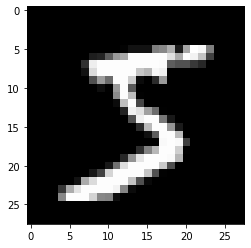

In [0]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

# 첫 번째 train data를 보여준다. 28*28 = 784.

In [0]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape 
# nd은 총 데이터 양, c는 columns.
x_train.shape, y_train.min(), y_train.max()

# map function은 리스트나 튜플을 지정함수로 처리해주는 역할을 함. 
# mab(a, b)라고 한다면 a는 함수 b에 전달할 매개변수를 쓰면 된다. 
# 이경우 mnist dataset(train dataset, valid dataset)를 모두 tensor형으로 만들어줌. 

# 현재 data sample은 numpy.arays이며 tensor여야 함. 

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) 
# mnist dataset으로 DataBunch를 만듦. 

# mini-batch를 원함. mini-batch를 위해 TensorDataset이란 도구를 사용. 
# 2개의 tensor로 dataset을 만들 수 있다. 

In [0]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

# iter : 반복을 끝낼 값을 지정하면 특정 값이 나올 때 반복을 끝냄. 
# iter(호출 가능한 객체(data.train_dl), 반복을 끝낼 값)
# 반복을 계속 하다가 반복을 끝낼 값이 나오면 StopIteration이 발생하는데, 이 때까지 무작위로 객체가 생성된다. 
# next : default 지정 가능. default을 지정하면 반복이 끝나더라도 멈추지 않고 default을 출력. 
# next(반복 가능한 객체, default)

# mini-batch : 64.

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
# y_hat = x@a 대신에 nn을 만들었음. 
# 선형 레이어 구조를 저장하는 속성을 만드는 것. 

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True) # x@a + b.

    def forward(self, xb): return self.lin(xb) # xb : x의 작은 batch를 나타냄.

# xb를 self.lin에 주면 a@x + b의 결과를 반환할 수 있는 것임.    
# 로지스틱 회귀 모델이라고 함. 



> nn.module

기존 모듈과 다른 것을 수행하기 위해 nn.Module을 build하려면 그 위에 sub class를 build해야 한다. pytorch에서 sub class 작성은 매우 일반적인 작업임. 


In [0]:
model = Mnist_Logistic().cuda()

# CUDA는 NVDIA가 만든 기술로 GPU에서 수행하는 알고리즘을 C 언어를 비롯한 
# 각종 산업 표준 언어를 사용하여 작성할 수 있도록 하는 기술이다. 

# 모델을 수동으로 구축하기 때문에 GPU에 매개변수 매트릭스를 수동으로 배치해야한다. 

In [0]:
model
# 이 모델인 nn임. 이 모듈은 자동으로 모델을 제공함. 
# 모델은 일련의 메소드와 함수 및 속성을 자동으로 생성함. 

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape
# 예측값(y_hat)의 shape.

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()]
# 784개의 입력값을 받아들이고 10개의 출력값을 반환한다는 의미.
# 입력값이 784 차원이고 10개의 확률값을 출력해야하므로 편리함.  
# 이후 10개의 활성화 값이 있음. 그런 다음 bias를 추가. 

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2
# learning rate. 

In [0]:
loss_func = nn.CrossEntropyLoss()
# loss function. cross entropy loss를 쓴다. 
# MSE 안씀. 3을 0으로 예측하거나 4로 예측하거나 도찐개찐. 

In [0]:
# lesson2 SGD notebook에서 카피함. 

def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0. 
    # 각 매개변수 행렬을 하나씩 가져와서 매개변수 행렬의 제곱합을 w2에 더함. 
    # w2는 모든 모수 행렬의 제곱합을 포함함. 
    for p in model.parameters(): w2 += (p**2).sum() # 여기까지 weight decay. 
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd # MSE 대신. 
    loss.backward()
    with torch.no_grad(): # pytorch가 모든 매개변수 목록을 자동으로 생성함. __init__()에 내장되어있음. 
        for p in model.parameters():
            p.sub_(lr * p.grad) # parameter = parameter - learning rate*gradient. 
            p.grad.zero_()
    return loss.item()
# tensor는 모든 계산이 GPU에서 방금 이뤄졌기 때문에 모든 데이터는 GPU의 gradient며 많은 메모리를 차지함. 
# 1차원 tensor에 대해 .item()을 실행하면 일반적인 python값이 반환된다. 그러면 graph를 만들 수 있는 것임. 



> weight decay

weight decay는 신경망을 훈련할 때만 유용함. gradient를 만들어야 하므로. 이 부분은 parameter를 업데이트하는 데 도움이 됨. wd*parameter sum of squares. 이 수식에 대해 w로 미분하였더니 일정한 상수와 parameter를 곱한 꼴이 되었음.(강의에서) 따라서 weight decay는 각 batch 계산에서 일정한 상수와 parameter를 빼서 수행하게 되는 것임. 이게 weight가 약해지는 이유. 이 식에 weight 감소가 존재하면, loss에 parameter sum of squaere을 추가하면, L2 정규화(L2 regularzation)라고 함. 


In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]
# DataLoader를 탐색하면 모든 mini-batch를 하나씩 제공함. 

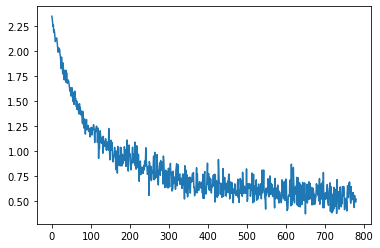

In [0]:
plt.plot(losses);
# loss가 낮아질수록 더 강하게 진동하는 것을 볼 수 있음.  

In [0]:
# Mnist_logistic을 대체하고 Mnist_NN을 사용하여 처음부터 신경망을 구축할 것임. 
# update(), 즉 gradient에서 내려갈 수 있는 기능이 있으면 다른 model을 사용해볼 수 있음. 

class Mnist_NN(nn.Module): 
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True) # 50 columns. 
        self.lin2 = nn.Linear(50, 10, bias=True) # 10 : 예측 범주의 수. 
        # 2개의 linear layer.
    def forward(self, xb): # relu를 구해서 두 번째 linear layer을 구성한다. 
        x = self.lin1(xb)
        x = F.relu(x) 
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

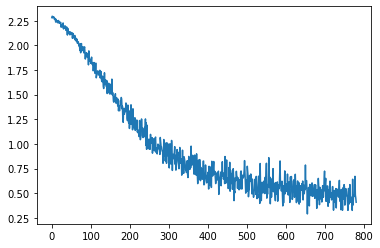

In [0]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr) # optim.SGD 사용 중. 하지만 Adam으로 교체할 수 있음.
    # Adam에 관해 01:44부터 함. 
    # opt = optim.Adam(model.parameters(), lr, weight_decay = wd) 추가 가능.  
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step() # p.sub_(lr*p.grad)랑 똑같은 코드. 
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x, y, 1e-3) for x,y in data.train_dl]

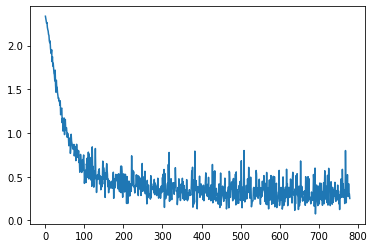

In [0]:
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)
# 최적화 알고리즘을 사용하는 경향이 없음. 학습자를 더 사용함. 
# learner는 nn의 하위 클래스임. metrics는 프린트를 위함. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


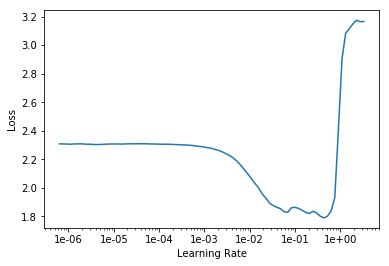

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.129131,0.125927,0.963500


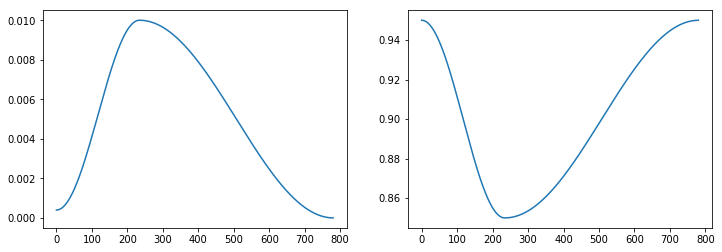

In [0]:
learn.recorder.plot_lr(show_moms=True)
# 최종 최적 결과에 근접하면 목표에 정확하게 도달하기 위해 학습 속도를 감소시켜야 함.
# 운동량(모멘텀)이 그려짐. 

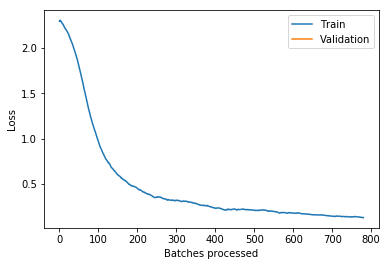

In [0]:
learn.recorder.plot_losses()

## fin